$$
\newcommand{\dd}{\text{d}}
\newcommand{\pdv}[2]{ \frac{\partial #1}{\partial #2}  }
\newcommand{\dv}[2]{ \frac{\dd #1}{\dd #2} }
$$

# Generalized Nonlinear Schrodinger Equation
Jared Callaham (2020)

A model for 1D pulse propagation in an optical fiber, in this case used to study a phenomenon called supercontinuum generation.  The model is derived from Maxwell's equations with nonlinear and time-delayed polarization effects.  Once the model is nondimensionalized using soliton scaling,

\begin{gather}
\label{eq:gnlse}
\pdv{u}{x} - \sum_{k=2}^{\infty} \alpha_k \frac{\partial^k u}{\partial t^k} = \left(i - \pdv{}{t}\right) u \int_{-\infty}^{\infty} r(t') | u(t') |^2 \dd t' \\
r(t) = a \delta(t) + b \exp (ct) \sin (dt) \Theta(t)
\end{gather}

The various constants depend on the propagation medium.  The delta function in the integrand becomes the cubic Kerr nonlinearity, while the Heaviside term leads to a time-delayed convolutional integral which we will refer to as the Raman nonlinearity. With only the cubic nonlinearity, the equation is similar to the familiar nonlinear Schrodinger equation, but with higher-order dispersion. The balance between dispersion and the cubic nonlinearity can propagate soliton waves.  The Raman term is presumed to be important in the supercontinuum generation process and should be active at least near the origin.

__NOTE:__ For a more detailed explanation of the process, see the notebook on the Burgers equation.

__SEPARATE KERR AND RAMAN TERMS__

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import randint
import scipy.io as sio

import matplotlib as mpl
mpl.rc('text', usetex=True)
mpl.rc('font', family='serif')
mpl.rc('xtick', labelsize=14)
mpl.rc('ytick', labelsize=14)
mpl.rc('axes', labelsize=20)
mpl.rc('axes', titlesize=20)
%config InlineBackend.figure_format = 'retina'

from sklearn.mixture import GaussianMixture
from sklearn.decomposition import SparsePCA

# Seaborn colormap
import seaborn as sns
from matplotlib.colors import ListedColormap
sns_list = sns.color_palette('deep').as_hex()
sns_list.insert(0, '#ffffff')  # Insert white at zero position
sns_cmap = ListedColormap(sns_list)

cm = sns_cmap

Data is simulated using MATLAB code due to J.C. Travers, M.H Frosz and J.M. Dudley (2009), which is freely available [here](http://www.scgbook.info/). The simulation ran through 10th order time derivatives and the various terms are extracted directly from the code for accuracy.

In [2]:
data = sio.loadmat('./data/gnlse_nondim.mat')

x = data['x'][:, 0]
t = data['t'][0, :]
u = data['u']
ux = data['ux']
du_dt = data['du_dt'][0, :]
raman = data['raman'] + data['kerr']

Visualize the field in log-scale EM intensity (adapted from the original MATLAB code).  One dominant feature is the soliton ejected from the origin (darkest streak)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.


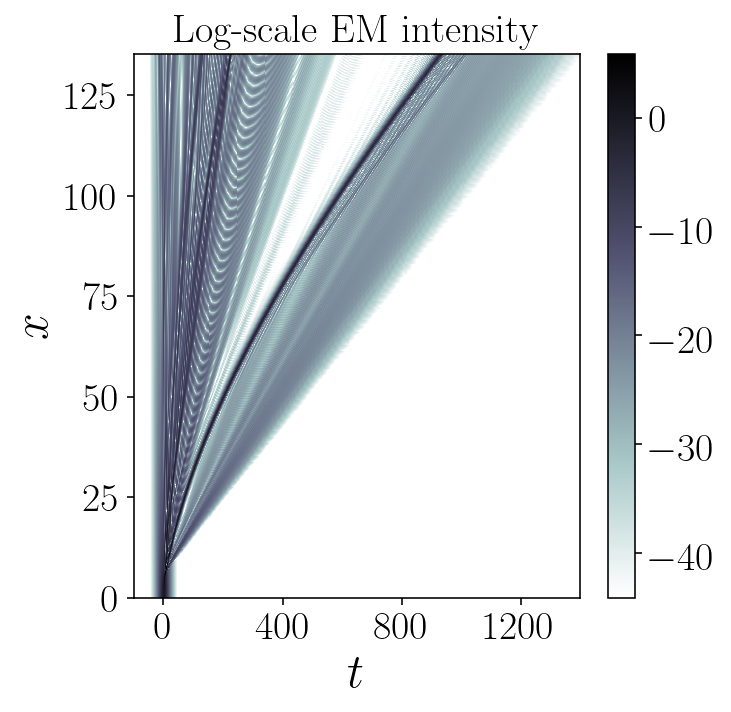

In [3]:
# Number of time derivative terms to include (cluster conditioning is better without full order)
order = 6
trange = [-100, 1400]  # Range for plotting

dt = t[1] - t[0]
dx = x[1] - x[0]
n = len(t) # grid size

# Compute log scale intensity
it = lambda field: 10*np.log10(abs(field)**2) 

## Plot energy content in temporal domain (from Travers code)
plt.figure(figsize=(5, 5))

lIT = it(u); # log scale temporal intensity
mlIT = max(lIT.flatten())       # max value, for scaling plot
#plt.pcolor(t, x, lIT, cmap='viridis');          # plot as pseudocolor map
plt.imshow(lIT, cmap='bone_r', origin='lower', vmin=mlIT-50.0, vmax=mlIT,
          extent=[min(t), max(t), min(x), max(x)], aspect='auto')          # plot as pseudocolor map
plt.xlim(trange);
plt.xlabel('Delay')
plt.ylabel('Distance')
plt.title('Log-scale EM intensity')
cb = plt.colorbar()
cb.ax.tick_params(labelsize=20)

plt.xlabel('$t$', fontsize=24)
plt.ylabel('$x$', fontsize=24)
plt.gca().tick_params(labelsize=20)
plt.gca().set_xticks(np.arange(0, 1300, 400))

plt.show()

For some intuition, we might start by looking at all of the constituent terms individually. Note that the nonlinearities are primarily active in the soliton region, which the dominant activity in the rest of the field is higher-order dispersion.

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.


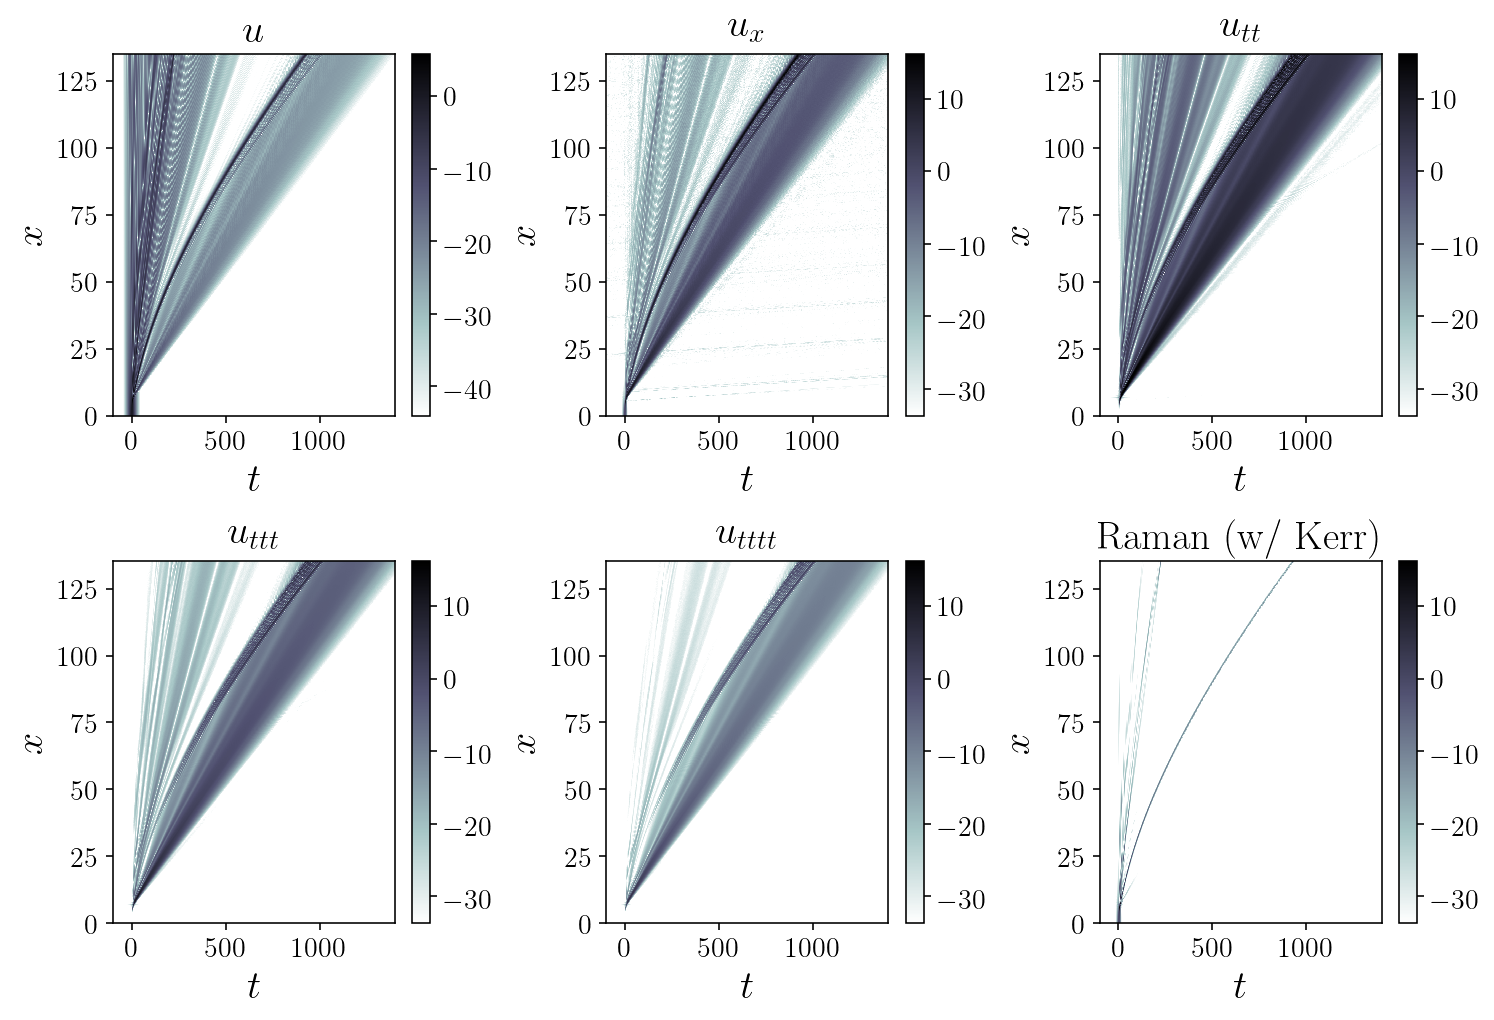

In [4]:
## Plot colormaps of different RHS terms in library
delta_x = 50;  # Spatial window
delta_t = 150; # Temporal window 
shift_x = 5;   # How far to slide the window
shift_t = 20;  # 

#x0 = np.arange(delta_x//2, len(x)-delta_x//2, shift_x)  # Centers of window, in index coordinates
#t0 = np.arange(tmin, length(t)-delta_t//2, shift_t)
x0 = np.arange(len(x))
t0 = np.arange(len(t));  # No downsampling

plt.figure(figsize=(12, 8));

plt.subplot(2, 3, 1)
# Plot full field intensity
C = it(u);
plt.imshow(C, cmap='bone_r', origin='lower', vmin=mlIT-50.0, vmax=mlIT,
          extent=[min(t), max(t), min(x), max(x)], aspect='auto');          # plot as pseudocolor map
plt.xlim(trange);
plt.xlabel('$t$')
plt.ylabel('$x$');
plt.colorbar()
plt.title('$u$')

plt.subplot(2, 3, 2);
# LHS
C = it(ux);
mlIT = max(C.flatten())
plt.imshow(C, cmap='bone_r', origin='lower', vmin=mlIT-50.0, vmax=mlIT,
          extent=[min(t), max(t), min(x), max(x)], aspect='auto');          # plot as pseudocolor map
plt.xlim(trange);
plt.xlabel('$t$')
plt.ylabel('$x$');
plt.colorbar()
plt.title('$u_x$')

plt.subplot(2, 3, 3);
C = it( du_dt[2] );
plt.imshow(C, cmap='bone_r', origin='lower', vmin=mlIT-50.0, vmax=mlIT,
          extent=[min(t), max(t), min(x), max(x)], aspect='auto');          # plot as pseudocolor map
plt.xlim(trange);
plt.xlabel('$t$')
plt.ylabel('$x$');
plt.colorbar()
plt.title('$u_{tt}$')

plt.subplot(2, 3, 4);
C = it( du_dt[3] );
plt.imshow(C, cmap='bone_r', origin='lower', vmin=mlIT-50.0, vmax=mlIT,
          extent=[min(t), max(t), min(x), max(x)], aspect='auto');          # plot as pseudocolor map
plt.xlim(trange);
plt.xlabel('$t$')
plt.ylabel('$x$');
plt.colorbar()
plt.title('$u_{ttt}$')


plt.subplot(2, 3, 5);
C = it( du_dt[4] );
plt.imshow(C, cmap='bone_r', origin='lower', vmin=mlIT-50.0, vmax=mlIT,
          extent=[min(t), max(t), min(x), max(x)], aspect='auto');          # plot as pseudocolor map
plt.xlim(trange);
plt.xlabel('$t$')
plt.ylabel('$x$');
plt.colorbar()
plt.title('$u_{tttt}$')


plt.subplot(2, 3, 6);
C = it( raman ); 
plt.imshow(C, cmap='bone_r', origin='lower', vmin=mlIT-50.0, vmax=mlIT,
          extent=[min(t), max(t), min(x), max(x)], aspect='auto');          # plot as pseudocolor map
plt.xlim(trange);
plt.xlabel('$t$')
plt.ylabel('$x$');
plt.colorbar()
plt.title('Raman (w/ Kerr)')

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.4)
plt.show()

### 1. Construct feature matrix (equation space representation)
The data is high-resolution enough that keeping every point for clustering is unnecessary.  For training we'll downsample the fields.

Also note that the fields in this case are complex, which is a challenge for the Gaussian mixture modeling. Since we only care about zero-nonzero variance, an easy way around this is to stack the real and imaginary components.  The model will still tell us whether the variance is significant, regardless of whether it is in the real or imaginary directions.

In [5]:
# Build feature library
nfeatures = order+1 # features: [(order-1) time derivatives, Kerr, Raman, spatial derivative]
featuremap = np.zeros([len(x), len(t), nfeatures], dtype='complex64');
for n in range(2, order+1):
    featuremap[:, :, n-2] = du_dt[n]

featuremap[:, :, -2] = raman
featuremap[:, :, -1] = ux

# Downsample for building model
shift_x, shift_t = 5, 10
tmin = np.nonzero(t > -100)[0][0]

x0 = np.arange(0, len(x), shift_x)
t0 = np.arange(tmin, len(t), shift_t)
featuremap = featuremap[x0, :, :]
featuremap = featuremap[:, t0, :]

# Leave out near-zero field values (numerical noise and essentially zero dynamics)
lIT = it(u)
lIT = lIT[x0, :]
lIT = lIT[:, t0]
mlIT = max(lIT.flatten())
mask = lIT > mlIT-40.0

features = np.reshape(featuremap, [len(x0)*len(t0), nfeatures], order='F')
features = features[mask.flatten('F'), :]
features = np.hstack((np.real(features), np.imag(features))) # Treat real/imag as separate features

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.


### 2. Gaussian mixture model clustering

In [6]:
# Fit to GMM and plot covariance matrices
nc = 8

#seed = np.random.randint(2**32)

#  Keep a random seed for plot reproducibility
seed = 2676815203  # Sparse model (although no Raman)
print(seed)
model = GaussianMixture(n_components=nc, random_state=seed)

model.fit(features)

2676815203


GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=8, n_init=1, precisions_init=None,
                random_state=2676815203, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

Now that we fit the model on limited data, "predict" for the full domain

In [7]:
# Recompute features for full domain
nfeatures = order+1 # (order-1) derivatives, 2 nonlinear terms, and spatial derivative
featuremap = np.zeros([len(x), len(t), nfeatures], dtype='complex64');
for n in range(2, order+1):
    featuremap[:, :, n-2] = du_dt[n]

featuremap[:, :, -2] = raman
featuremap[:, :, -1] = ux

tmin = np.nonzero(t > -100)[0][0]

t0 = np.arange(tmin, len(t))
featuremap = featuremap[:, t0, :];

# Mask by nonzero field values
lIT = it(u)
lIT = lIT[:, t0]
mlIT = max(lIT.flatten())
mask = lIT > mlIT-40.0  # Get rid of tiny values in the field

features = np.reshape(featuremap, [len(x)*len(t0), nfeatures], order='F');
features = features[mask.flatten('F'), :]
features = np.hstack((np.real(features), np.imag(features))) # Treat real/imag as separate features

# Cluster domain based on previously trained GMM
cluster_idx = model.predict(features)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.


Visualize the clustering results across the field

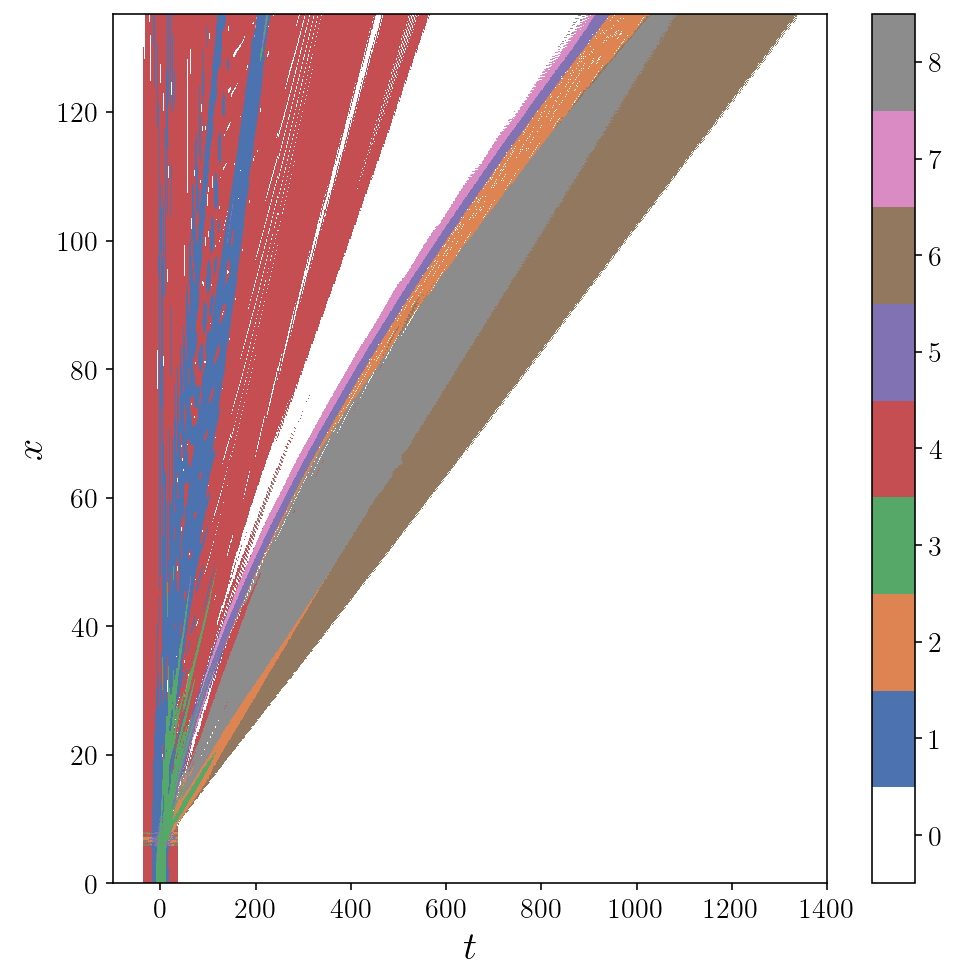

In [8]:
# Colormap of clusters
clustermap = np.zeros([len(x)*len(t0)])
clustermap[mask.flatten('F')] = cluster_idx+1  # Index into unmasked regions
clustermap = np.reshape(clustermap, [len(x), len(t0)], order='F')

plt.figure(figsize=(8, 8))
plt.imshow(clustermap, cmap=cm, vmin=-0.5, vmax=cm.N-0.5, origin='lower',
          extent=[-100, max(t), min(x), max(x)], aspect='auto'); 

plt.xlabel('$t$')
plt.ylabel('$x$')

plt.xlim(trange)
plt.colorbar(boundaries=np.arange(-0.5, nc+1.5), ticks=np.arange(0, nc+1))
plt.show()

### 3. SPCA reduction
As usual, from the similarity between covariance matrices and approximate sparsity, we expect there to be redundant clusters and many near-zero entries.

First, a sweep across regularization weights to choose one appropriately

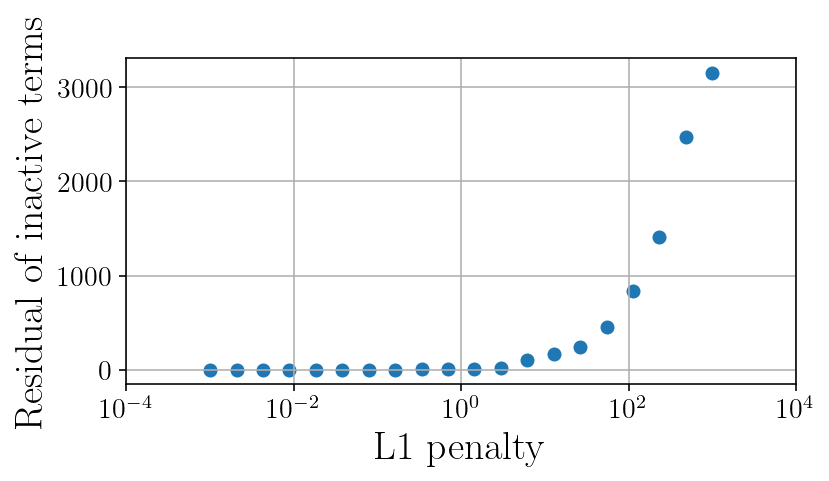

In [15]:
# Sparse PCA to identify directions of nonzero variance
#   First step: model selection for L1 regularization
alphas = np.logspace(-3, 3, 20)
err = np.zeros([len(alphas)])  # Error defined as norm of inactive terms

for k in range(len(alphas)):
    for i in range(nc):
        # Identify points in the field corresponding to each cluster
        feature_idx = np.nonzero(cluster_idx==i)[0]
        cluster_features = features[feature_idx, :nfeatures]  
        spca = SparsePCA(n_components=1, alpha=alphas[k], normalize_components=True)
        spca.fit(cluster_features)
        active_terms = np.nonzero(spca.components_[0])[0]
        inactive_terms = [feat for feat in range(nfeatures) if feat not in active_terms ]
        
        err[k] += np.linalg.norm(cluster_features[:, inactive_terms])
        
plt.figure(figsize=(6, 3))
plt.scatter(alphas, err)
plt.xlabel('L1 penalty')
plt.ylabel('Residual of inactive terms')
plt.gca().set_xscale('log')
plt.xlim([1e-4, 1e4])
plt.grid()
plt.show()

It is not obvious what regularization to choose, suggesting the balance phenomenon is weaker in this case than some of the other examples.  To get a more accurate model, we should choose a lighter regularization that preserves much of the dynamics ($\alpha=1$). On the other hand, to study the leading-order behavior we could choose a more sparse model ($\alpha=10$) which is a worse approximation but may be more insightful.

The best choice will depend on the application, but in general care should be taken in drawing strong conclusions from this analysis when there the signature of dominant balance is not as strong.

Continuing with the SPCA reduction:

In [10]:
alpha_opt = 10

spca_model = np.zeros([nc, nfeatures])
for i in range(nc):
    feature_idx = np.nonzero(cluster_idx==i)[0]
    cluster_features = features[feature_idx, :nfeatures]
    spca = SparsePCA(n_components=1, alpha=alpha_opt, normalize_components=True)
    spca.fit(cluster_features)
    print('GMM Cluster {0}:'.format(i+1))
    active_terms = np.nonzero(spca.components_[0])[0]
    print(active_terms)
    spca_model[i, active_terms] = 1  # Set to 1 for active terms in model
    

GMM Cluster 1:
[0 1 6]
GMM Cluster 2:
[0 1 2 3 4 6]
GMM Cluster 3:
[0 1 2 3 6]
GMM Cluster 4:
[0 1 2 6]
GMM Cluster 5:
[0 2 5 6]
GMM Cluster 6:
[0 1 2 3 4 6]
GMM Cluster 7:
[0 6]
GMM Cluster 8:
[0 1 2 3 4 6]


### 4. Final balance models

We find a region near the origin where high-order dispersion and the Raman nonlinearity are both important, several regions characterized by various linear dispersion relations, and a nonlinear model that captures the soliton.

[[1. 0. 0. 0. 0. 0. 1.]
 [1. 0. 1. 0. 0. 1. 1.]
 [1. 1. 0. 0. 0. 0. 1.]
 [1. 1. 1. 0. 0. 0. 1.]
 [1. 1. 1. 1. 0. 0. 1.]
 [1. 1. 1. 1. 1. 0. 1.]]
SPCA Cluster 1:
[0 6]
SPCA Cluster 2:
[0 2 5 6]
SPCA Cluster 3:
[0 1 6]
SPCA Cluster 4:
[0 1 2 6]
SPCA Cluster 5:
[0 1 2 3 6]
SPCA Cluster 6:
[0 1 2 3 4 6]


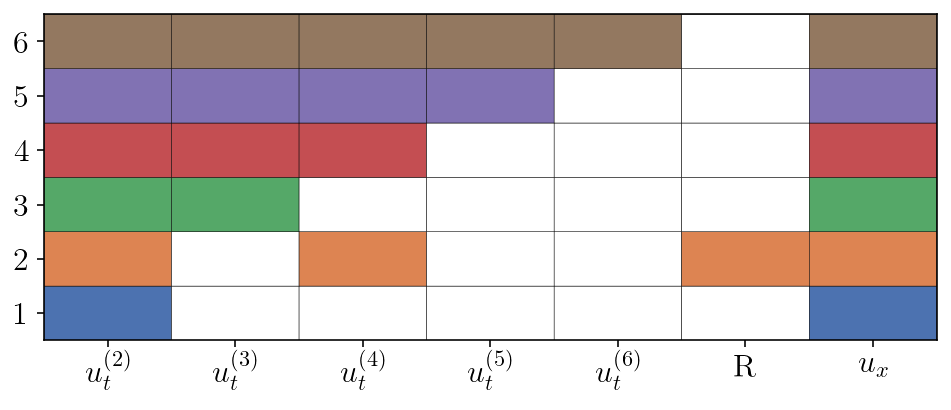

In [11]:
labels = ['$u^{(2)}_t$', '$u^{(3)}_t$', '$u^{(4)}_t$', '$u^{(5)}_t$', '$u^{(6)}_t$', 'R', '$u_x$']

balance_models, model_index = np.unique(spca_model, axis=0, return_inverse=True)
nmodels = balance_models.shape[0]
print(balance_models)

for i in range(nmodels):
    print('SPCA Cluster {0}:'.format(i+1))
    active_terms = np.nonzero(balance_models[i, :])[0]
    print(active_terms)

# Make new cluster_idx based on SPCA balance model
balance_idx = np.array([model_index[i] for i in cluster_idx])
balancemap = np.zeros([len(t0)*len(x)])
balancemap[mask.flatten('F')] = balance_idx+1
balancemap = np.reshape(balancemap, [len(x), len(t0)], order='F')

gridmap = (balance_models.T*np.arange(1, nmodels+1)).T
#gridmap[gridmap==0] = np.NaN

plt.figure(figsize=(8, 3))
plt.pcolor(gridmap, vmin=-0.5, vmax=cm.N-0.5, cmap=cm, edgecolors='k')
plt.gca().set_xticks(np.arange(0.5, nfeatures+0.5))
plt.gca().set_xticklabels(labels, fontsize=16)
plt.gca().set_yticks(np.arange(0.5, nmodels+0.5))
plt.gca().set_yticklabels(range(1, nc), fontsize=16)
plt.show()

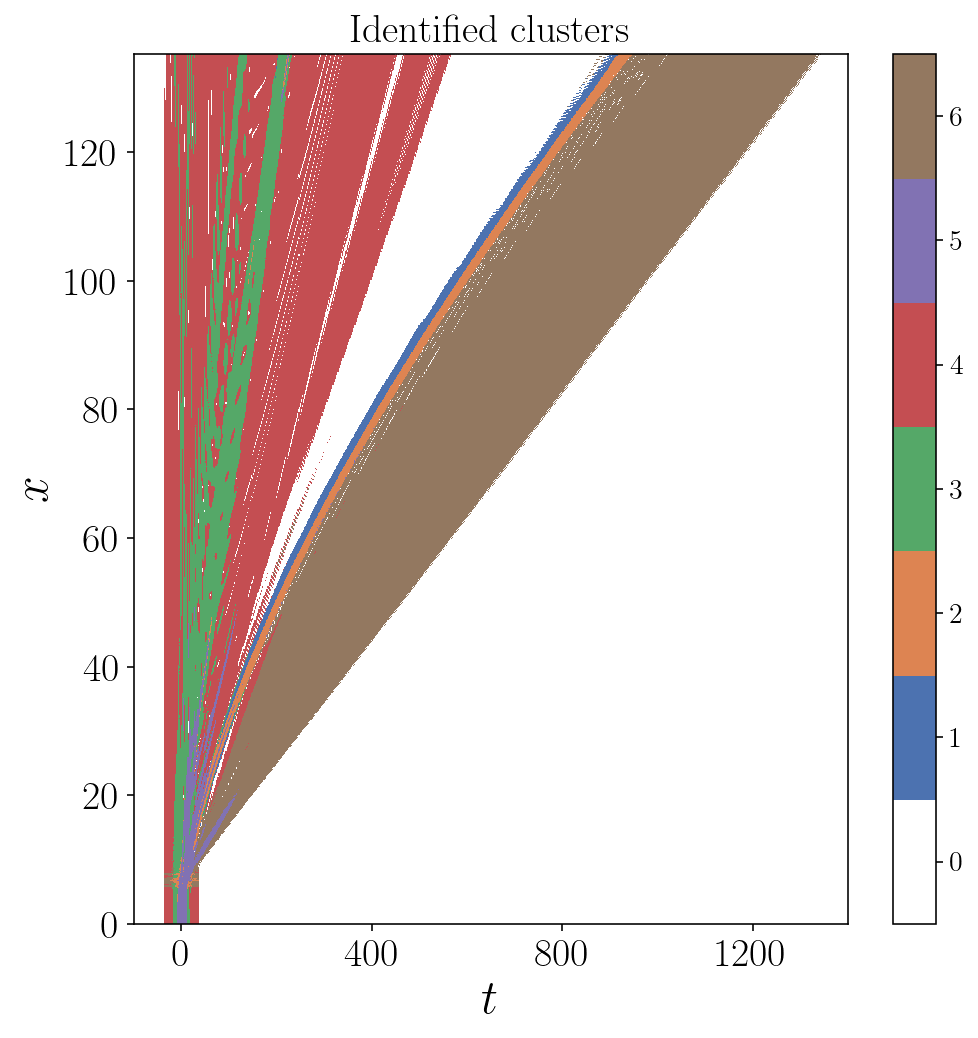

In [12]:
plt.figure(figsize=(8, 8))
plt.imshow(balancemap, cmap=cm, vmin=-0.5, vmax=cm.N-0.5, origin='lower',
          extent=[-100, max(t), min(x), max(x)], aspect='auto'); 

plt.xlim(trange)

plt.xlabel('$t$', fontsize=24)
plt.ylabel('$x$', fontsize=24)
plt.title('Identified clusters')
plt.gca().tick_params(labelsize=20)
plt.gca().set_xticks(np.arange(0, 1300, 400))

plt.colorbar(boundaries=np.arange(-0.5, nmodels+1.5), ticks=np.arange(0, nmodels+1))
plt.show()

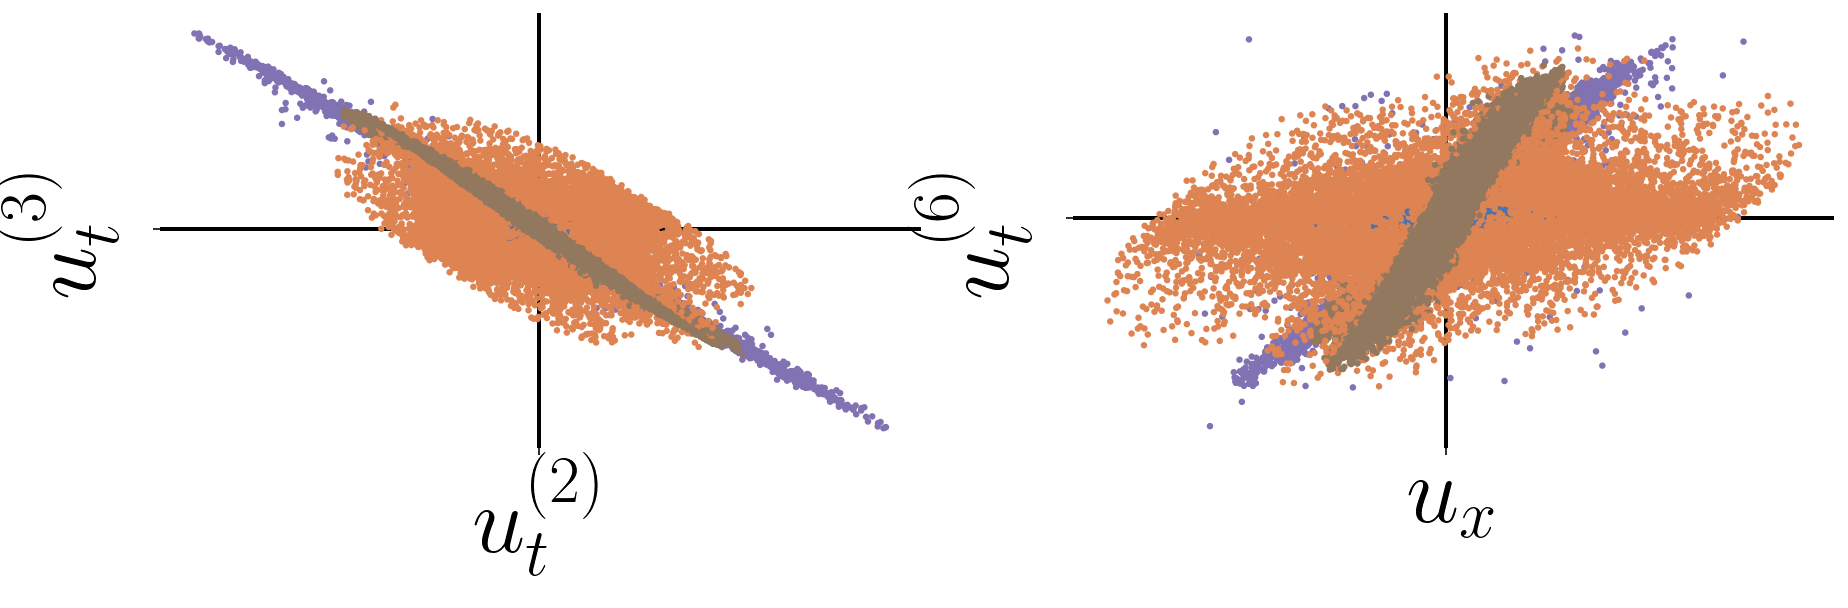

In [13]:
# Visualize some slices of equation space, color-coded by balance model
fontsize=48
markersize=5

plt.figure(figsize=(15, 4))
plt.subplot(121)
plt.grid(c='k', lw=2)
plt.gca().set_axisbelow(True)
plt.scatter(features[:, 0], features[:,1], markersize, balance_idx+1, cmap=cm)
plt.xlabel(labels[0], fontsize=fontsize)
plt.ylabel(labels[1], fontsize=fontsize)
plt.clim([-0.5, cm.N-0.5])
#plt.colorbar(boundaries=np.arange(-0.5, nmodels+1.5), ticks=np.arange(0, nmodels))

plt.gca().set_xticks([0])
plt.gca().set_xticklabels([''])
plt.gca().set_yticks([0])
plt.gca().set_yticklabels([''])

for axis in ['top','bottom','left','right']:
    plt.gca().spines[axis].set_linewidth(0)

plt.subplot(122)
plt.grid(c='k', lw=2)
plt.gca().set_axisbelow(True)
plt.scatter(features[:, -1], features[:,-3], markersize, balance_idx+1, cmap=cm)
plt.xlabel(labels[-1], fontsize=fontsize)
plt.ylabel(labels[-3], fontsize=fontsize)
plt.clim([-0.5, cm.N-0.5])
#plt.colorbar(boundaries=np.arange(-0.5, nmodels+1.5), ticks=np.arange(0, nmodels))

plt.gca().set_xticks([0])
plt.gca().set_xticklabels([''])
plt.gca().set_yticks([0])
plt.gca().set_yticklabels([''])

for axis in ['top','bottom','left','right']:
    plt.gca().spines[axis].set_linewidth(0)

plt.show()

3D plot showing the soliton is captured by the nonlinear balance

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.


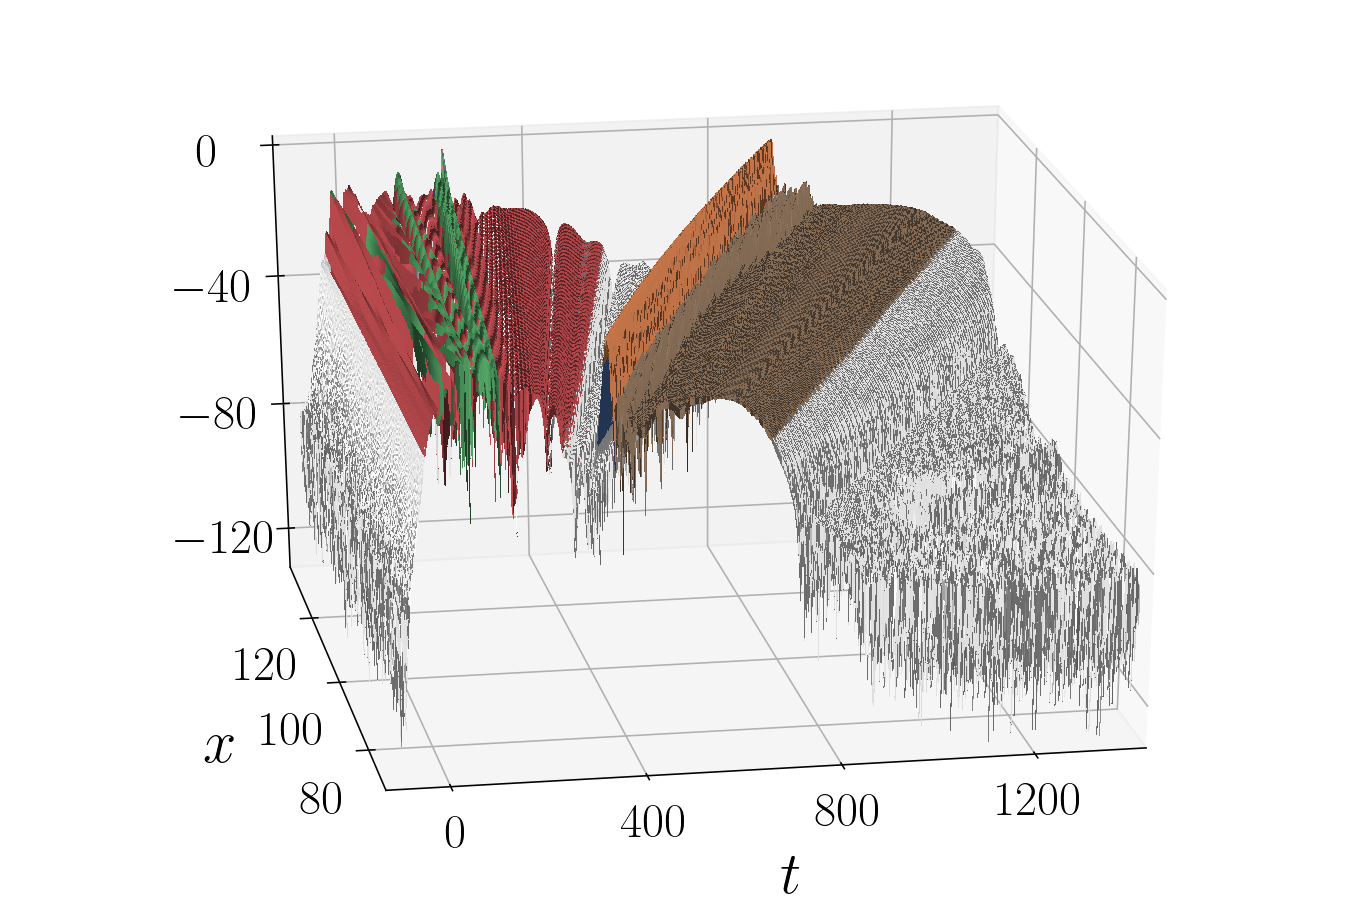

In [14]:
from mpl_toolkits.mplot3d import Axes3D

cm_array = np.array([cm(i) for i in range(cm.N)]) # Turn colormap into an array

# Build up color map for surface
c = np.zeros((balancemap.shape[0], balancemap.shape[1], 4))
for i in range(balancemap.shape[0]):
    for j in range(balancemap.shape[1]):
        c[i, j, :] = cm_array[int(balancemap[i, j]), :]
        
        
fig= plt.figure(figsize=(12, 8))
ax = fig.gca(projection='3d')

t_idx = (t>trange[0])*(t<trange[1])
x_idx = np.arange(len(x))>500

lIT = it(u); # log scale temporal intensity

T, X = np.meshgrid(t, x)
T_plt = T[:, t_idx]
T_plt = T_plt[x_idx, :]
X_plt = X[:, t_idx]
X_plt = X_plt[x_idx, :]

# Restrict to plotting window
c = c[x_idx, :, :]
c = c[:, t_idx[-c.shape[1]:], :]

lIT_plt = lIT[:, t_idx]
lIT_plt = lIT_plt[x_idx, :]

surf = ax.plot_surface(T_plt, X_plt, lIT_plt, facecolors=c, linewidth=0, antialiased=False, shade=True, rstride=1)

ax.view_init(elev=25., azim=260)
ax.set_xlabel('$t$', fontsize=30, labelpad=25)
ax.set_ylabel('$x$', fontsize=30, labelpad=25)

ax.set_xlim(trange)
ax.set_ylim([70, max(x)])
ax.set_zlim([-130, 0])

ax.set_yticks(np.arange(80, 130, 20))
ax.set_xticks(np.arange(0, 1400, 400))
ax.set_zticks(np.arange(-120, 10, 40))
ax.xaxis.set_tick_params(labelsize=24)
ax.yaxis.set_tick_params(labelsize=24, pad=10)
ax.zaxis.set_tick_params(labelsize=24, pad=15)

plt.show()